Following this
---
https://towardsdatascience.com/a-step-by-step-guide-to-feature-engineering-for-multivariate-time-series-162ccf232e2f

In [48]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
plt.style.use('fivethirtyeight')
import seaborn as sns #For heatmap
from utils import add_time_lag_df

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb

%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [16]:
train_a = pd.read_parquet('data/A/train_targets.parquet')
train_b = pd.read_parquet('data/B/train_targets.parquet')
train_c = pd.read_parquet('data/C/train_targets.parquet')

# Estimated training data for each location
X_train_estimated_a = pd.read_parquet('data/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('data/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('data/C/X_train_estimated.parquet')

# Observed training data for each location
X_train_observed_a = pd.read_parquet('data/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('data/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('data/C/X_train_observed.parquet')

# Estimated test data for each location
X_test_estimated_a = pd.read_parquet('data/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('data/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('data/C/X_test_estimated.parquet')

For the sake of it looking at only one dataset.
Might do something else later

In [17]:
X_data = X_train_observed_a
Y_data = train_a
Y_data

,time,pv_measurement
0,2019-06-02 22:00:00,0.00
1,2019-06-02 23:00:00,0.00
2,2019-06-03 00:00:00,0.00
3,2019-06-03 01:00:00,0.00
4,2019-06-03 02:00:00,19.36
...,...,...
34080,2023-04-30 19:00:00,9.02
34081,2023-04-30 20:00:00,0.00
34082,2023-04-30 21:00:00,0.00
34083,2023-04-30 22:00:00,0.00


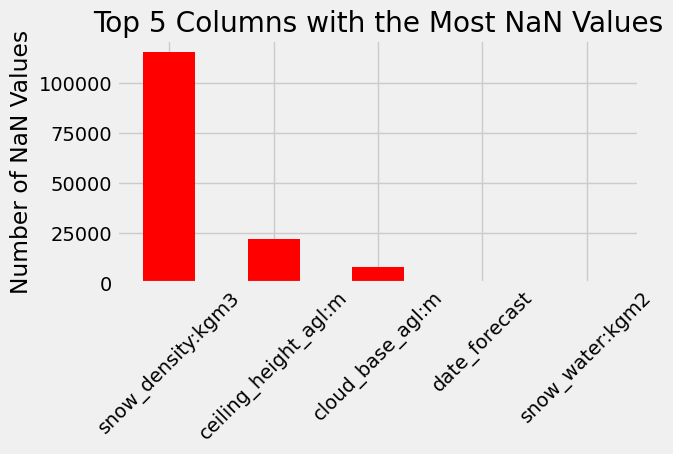

In [18]:
nan_count = X_data.isnull().sum()
sorted_nan_count = nan_count.sort_values(ascending=False)
N = 5  # Change this to the number of columns you want to plot
columns_to_plot = sorted_nan_count.head(N)
plt.figure(figsize=(6, 3))
columns_to_plot.plot(kind='bar', color='red')
plt.title(f'Top {N} Columns with the Most NaN Values')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=45)
plt.show()

I will remove snow density

In [19]:
X_data.drop(columns=['snow_density:kgm3', 'ceiling_height_agl:m', 'cloud_base_agl:m'], inplace=True)

In [20]:
X_data.rename(columns={'date_forecast': 'time'}, inplace=True)
X_data = X_data.set_index('time')
X_data = X_data.resample('H').mean()

Y_data.set_index('time')
data = pd.merge(X_data, Y_data, on="time")
data.set_index('time', inplace=True)

In [21]:
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) #remove the : characters etc. This is due json stuff. clear_sky_rad:W-> clear_sky_radW

In [24]:
import xgboost as xgb

Y = data['pv_measurement']
X = data.drop(columns=['pv_measurement'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

reg_full = xgb.XGBRegressor(n_estimators=1000)
reg_full.fit(X, Y)

/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

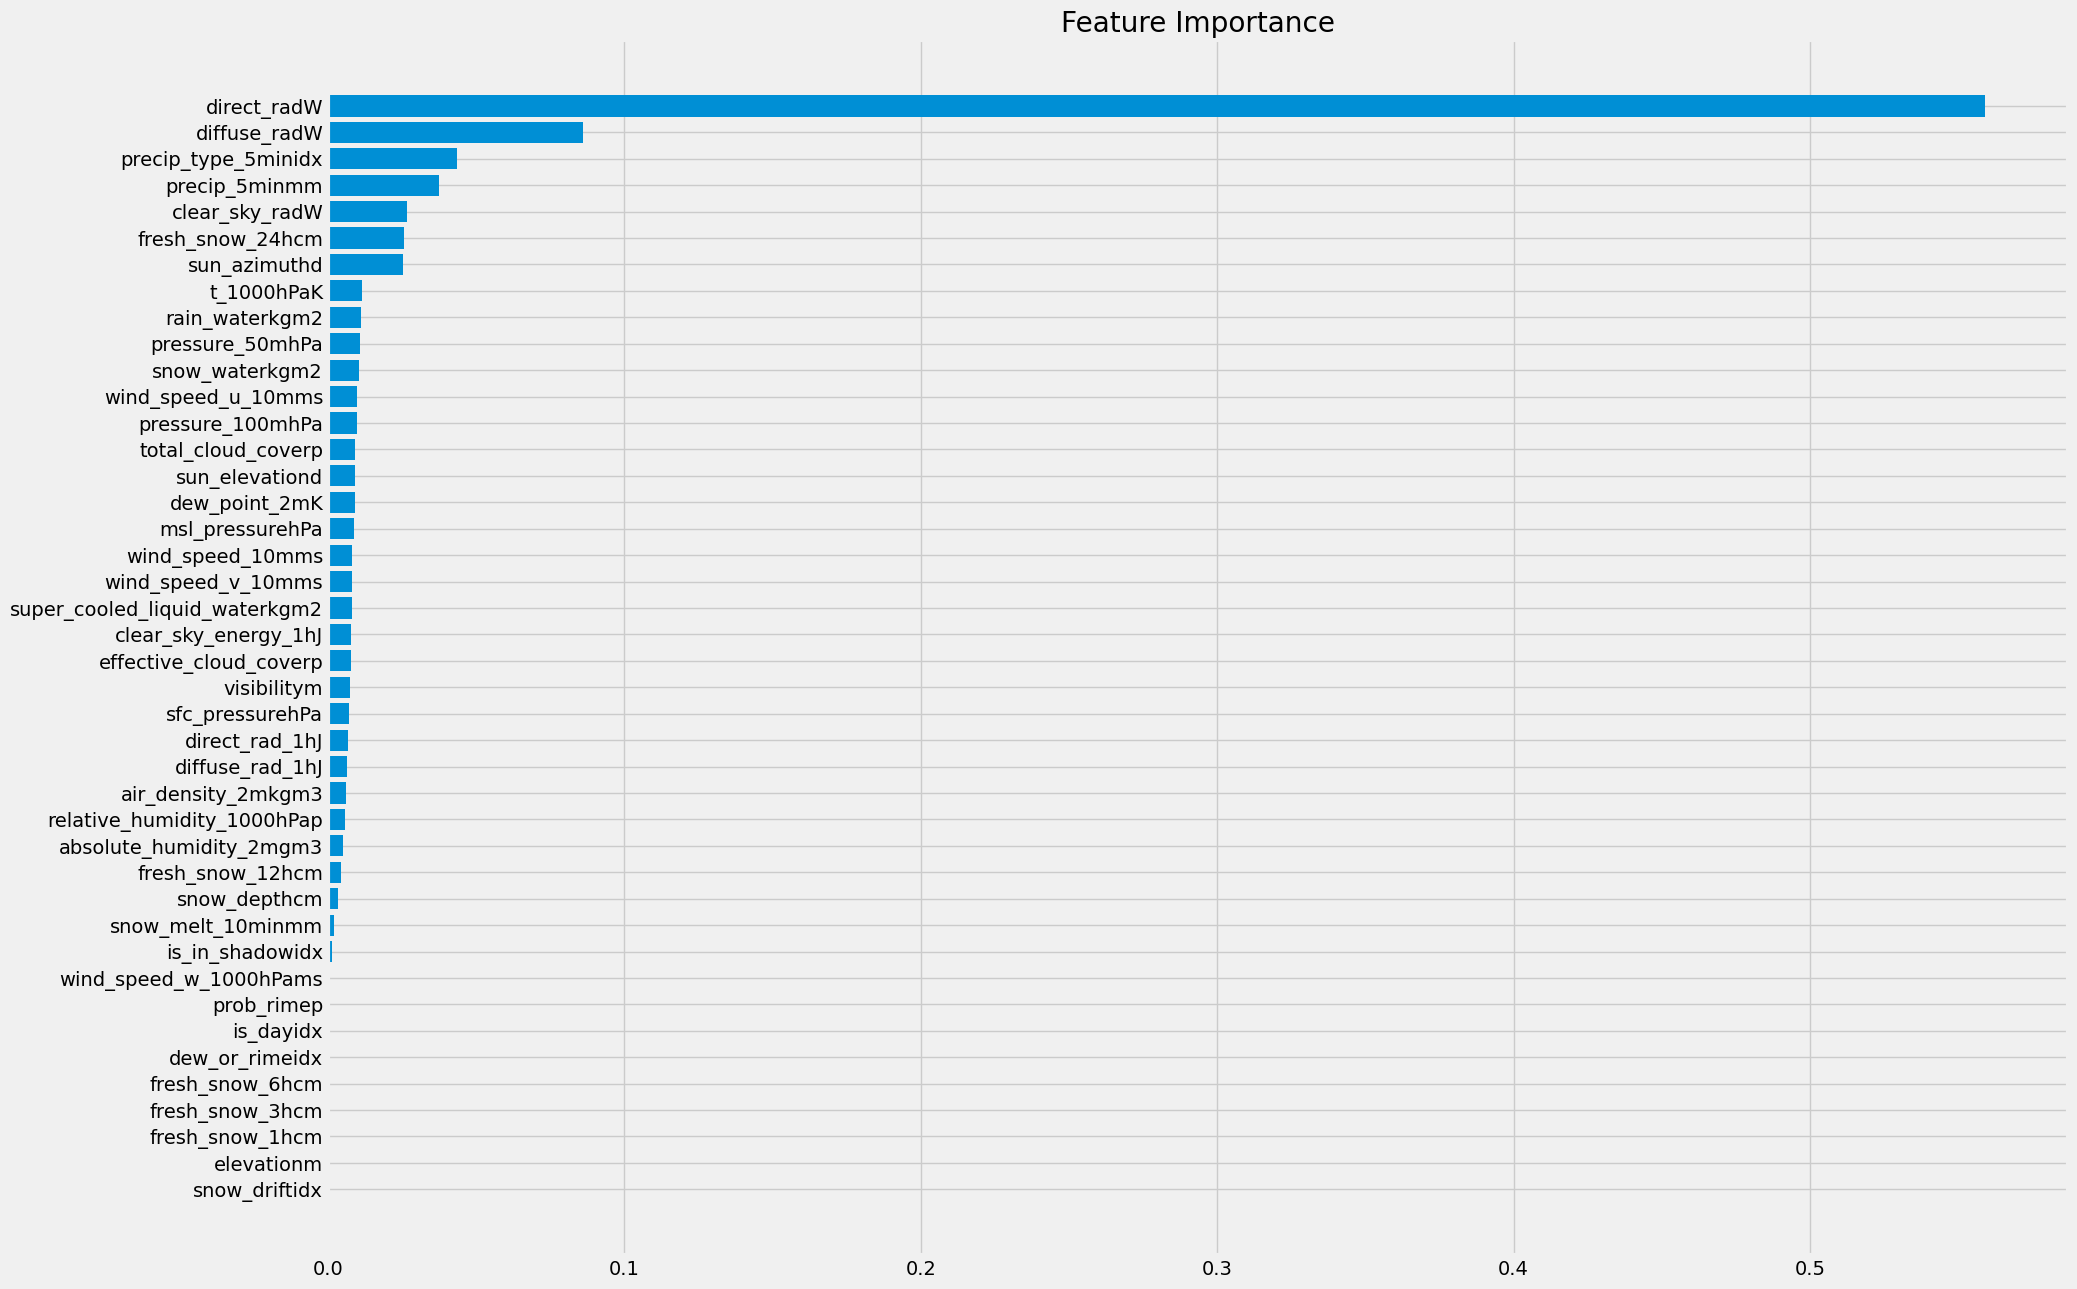

In [38]:

feature_importance = reg_full.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(20, 15))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

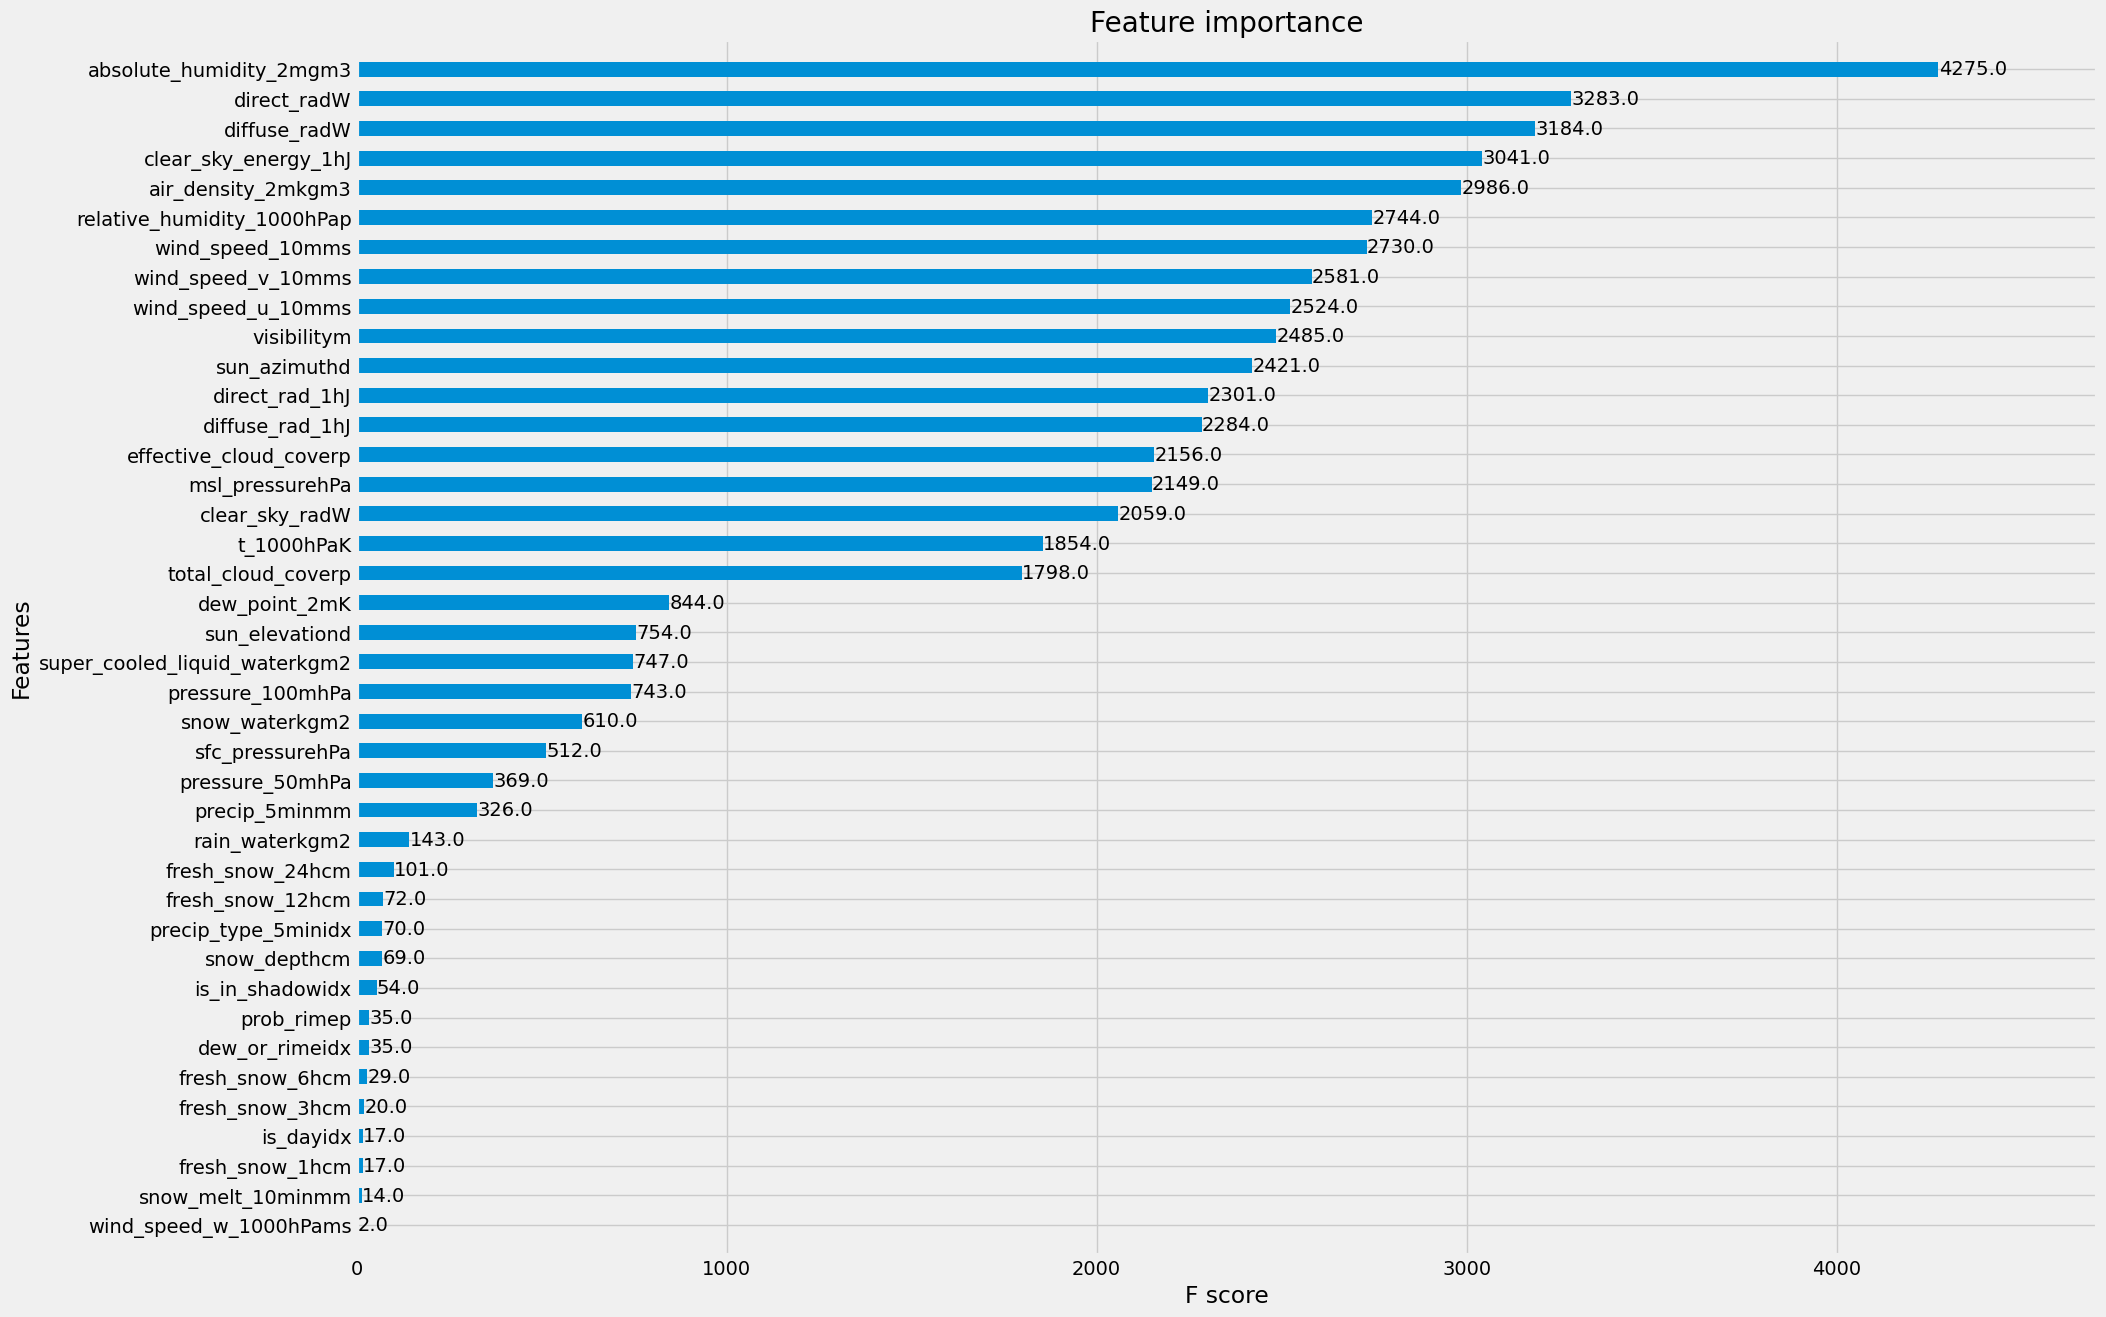

In [39]:
f, ax = plt.subplots(figsize=(20, 15))
xgb.plot_importance(reg_full, height=0.5, ax=ax)
plt.show()

Laplacian score and variance treshold

In [46]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=round(24*365*0.1), gap=24)
df = data.sort_index()

target = 'pv_measurement'

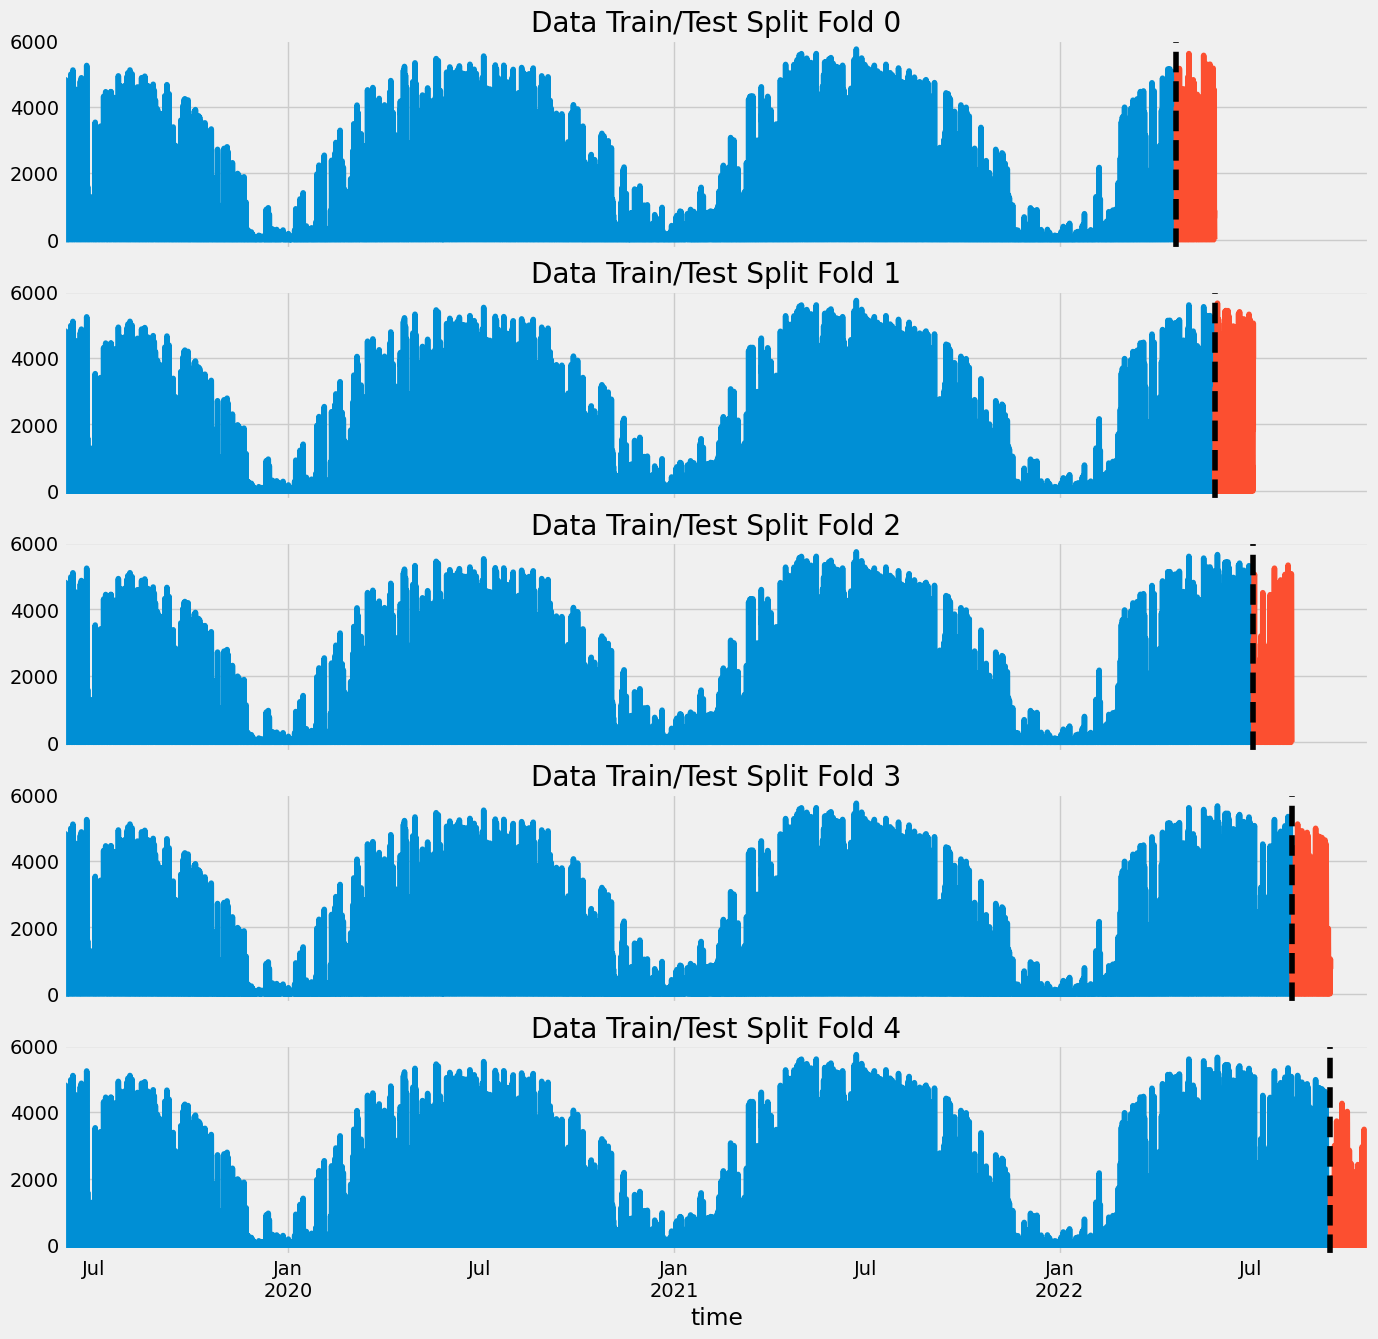

In [47]:
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)

fold = 0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train[target].plot(ax=axs[fold],
                       label='Training Set',
                       title=f'Data Train/Test Split Fold {fold}')
    test[target].plot(ax=axs[fold], label="Test Set")
    axs[fold].axvline(test.index.min(), color="black", ls='--')
    fold+=1

In [43]:
#df = add_time_lag_df(df) #figure out what time lag that is efficient.

In [53]:
from sklearn.metrics import mean_absolute_error as mae


maes = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    X_train = train.drop(columns=[target])
    Y_train = train[target]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds = 50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.1)
    
    reg.fit(X_train, Y_train,
            eval_set=[(X_train, Y_train), (X_test, Y_test)],
            verbose=100)
    
    Y_pred = reg.predict(X_test)
    score = mae(Y_pred, Y_test)
    maes.append(score)

[0]	validation_0-rmse:1206.45755	validation_1-rmse:1258.19773


/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/

[100]	validation_0-rmse:422.64448	validation_1-rmse:439.75923
[200]	validation_0-rmse:397.12322	validation_1-rmse:416.01767
[300]	validation_0-rmse:378.87869	validation_1-rmse:401.15194
[400]	validation_0-rmse:363.44558	validation_1-rmse:389.26915
[500]	validation_0-rmse:350.41202	validation_1-rmse:381.45338
[600]	validation_0-rmse:339.25271	validation_1-rmse:373.21925
[700]	validation_0-rmse:329.38518	validation_1-rmse:366.54845
[800]	validation_0-rmse:319.99929	validation_1-rmse:359.89845
[900]	validation_0-rmse:311.47481	validation_1-rmse:353.78563
[999]	validation_0-rmse:303.94087	validation_1-rmse:348.95706
[0]	validation_0-rmse:1224.56110	validation_1-rmse:1258.16771


/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/

[100]	validation_0-rmse:425.40270	validation_1-rmse:439.32441
[200]	validation_0-rmse:401.29199	validation_1-rmse:416.50422
[300]	validation_0-rmse:383.79306	validation_1-rmse:400.33793
[400]	validation_0-rmse:368.54891	validation_1-rmse:388.57313
[500]	validation_0-rmse:356.68981	validation_1-rmse:379.65900
[600]	validation_0-rmse:346.02562	validation_1-rmse:370.94735
[700]	validation_0-rmse:336.67199	validation_1-rmse:364.22556
[800]	validation_0-rmse:327.56355	validation_1-rmse:358.23473
[900]	validation_0-rmse:319.44991	validation_1-rmse:352.35796
[999]	validation_0-rmse:312.10763	validation_1-rmse:346.81768
[0]	validation_0-rmse:1248.22302	validation_1-rmse:1257.89689


/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/

[100]	validation_0-rmse:431.72327	validation_1-rmse:440.07800
[200]	validation_0-rmse:408.83566	validation_1-rmse:417.38848
[300]	validation_0-rmse:392.21773	validation_1-rmse:402.62495
[400]	validation_0-rmse:378.33371	validation_1-rmse:390.98446
[500]	validation_0-rmse:365.79304	validation_1-rmse:380.40556
[600]	validation_0-rmse:354.74115	validation_1-rmse:371.32683
[700]	validation_0-rmse:344.77572	validation_1-rmse:363.53184
[800]	validation_0-rmse:336.00216	validation_1-rmse:356.55472
[900]	validation_0-rmse:326.96268	validation_1-rmse:349.07150
[999]	validation_0-rmse:319.26052	validation_1-rmse:342.60341
[0]	validation_0-rmse:1254.76401	validation_1-rmse:1258.74550


/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/

[100]	validation_0-rmse:434.55559	validation_1-rmse:439.58080
[200]	validation_0-rmse:412.30332	validation_1-rmse:416.44662
[300]	validation_0-rmse:395.81615	validation_1-rmse:401.07177
[400]	validation_0-rmse:381.67447	validation_1-rmse:388.06062
[500]	validation_0-rmse:369.09972	validation_1-rmse:376.38253
[600]	validation_0-rmse:359.33486	validation_1-rmse:366.74370
[700]	validation_0-rmse:349.90206	validation_1-rmse:358.14219
[800]	validation_0-rmse:340.95433	validation_1-rmse:350.25520
[900]	validation_0-rmse:333.28177	validation_1-rmse:343.63841
[999]	validation_0-rmse:326.43985	validation_1-rmse:337.54923
[0]	validation_0-rmse:1268.29045	validation_1-rmse:1257.56184


/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/

[100]	validation_0-rmse:436.21642	validation_1-rmse:437.59675
[200]	validation_0-rmse:414.73877	validation_1-rmse:414.91910
[300]	validation_0-rmse:397.86346	validation_1-rmse:398.33586
[400]	validation_0-rmse:384.03583	validation_1-rmse:384.97690
[500]	validation_0-rmse:373.07448	validation_1-rmse:373.83826
[600]	validation_0-rmse:363.14718	validation_1-rmse:364.58269
[700]	validation_0-rmse:354.11604	validation_1-rmse:355.77688
[800]	validation_0-rmse:345.78820	validation_1-rmse:347.85895
[900]	validation_0-rmse:337.37787	validation_1-rmse:340.40418
[999]	validation_0-rmse:329.84741	validation_1-rmse:333.14408


/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/home/erlendlokna/Documents/ntnu/machinelearning/Solar-Energy-Prediction/.venv/

Cross val score:

In [56]:
np.mean(maes)

171.54369154956285